## Data provenance and characteristics:
 
### When and from where it was collected:
Data was collected from the GitHub presented in moodle:  https://github.com/Jl-wei/APIA2022-French-user-reviews-classification-dataset

### Text genre(s) and language(s) it covers
The data is purely made up of reviews on the app store, all of it written in French.

### How it has been annotated
Each entry in the data set is annotated with four labels: "Rating", "User Experience", "Feature request" and "Bug Report"
It also includes the score given by the user in each individual review.


## Pre-processing


### Importing the data 


In [221]:
import random

import nltk
import pandas as pd

# Read the data from the file
data_garmin_df = pd.read_csv('data/Garmin_Connect.csv')
data_samsung_df = pd.read_csv('data/Samsung_Health.csv')
data_huawei_df = pd.read_csv('data/Huawei_Health.csv')

data = pd.concat([data_garmin_df, data_samsung_df, data_huawei_df], ignore_index=True)
#data.to_csv('data/concatenated_data.csv', sep='\t', encoding='utf-8')

print(data.head(10))
print("\n Number of rows: " + str(len(data)))


                                                data  score  rating  \
0  Contrairement aux idées reçues le traceur GPS ...      5       1   
1               Application très pratique et fiable.      5       1   
2                                   jadore ma montre      5       1   
3  Super application, je l'utilise synchronisé av...      5       1   
4                                            Super !      5       1   
5  Application très pratique et très simple d'uti...      3       1   
6  Suivis du sommeil cardio nombre de pas avec la...      5       1   
7                                  Sympa et précis !      5       1   
8                                     Très satisfait      5       1   
9  bonjour, le calendrier ne se synchronise plus....      2       0   

   bug_report  feature_request  user_experience  
0           0                0                1  
1           0                0                0  
2           0                0                0  
3           0     

### Relevant plots

<AxesSubplot:>

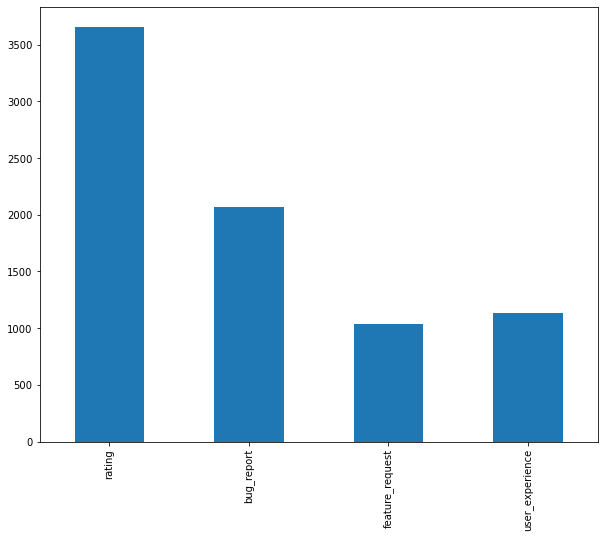

In [222]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

data_labels = data[["rating", "bug_report", "feature_request", "user_experience"]]

data_labels.sum(axis=0).plot.bar()

As we can see, the rating label is much more relevant than the other 3 labels, which causes unbalance and might mislead the results if not careful. Also, it seems that there are cases where more than 1 label can be applied. This makes it a multilabel problem:

![Types of classification problems (https://towardsdatascience.com/multilabel-text-classification-done-right-using-scikit-learn-and-stacked-generalization-f5df2defc3b5#6de1)](./data/Types_of_classification_problems.png "Types of classification problems")

To try to make this problem a binary one, one must make it so that the classification only hits one of the many label columns. That can be achieved by making all possible combinations columns in their own right. Or we can make it into a multiclass one by joining every label as a string in a new column "tags" and try to predict it.

<AxesSubplot:>

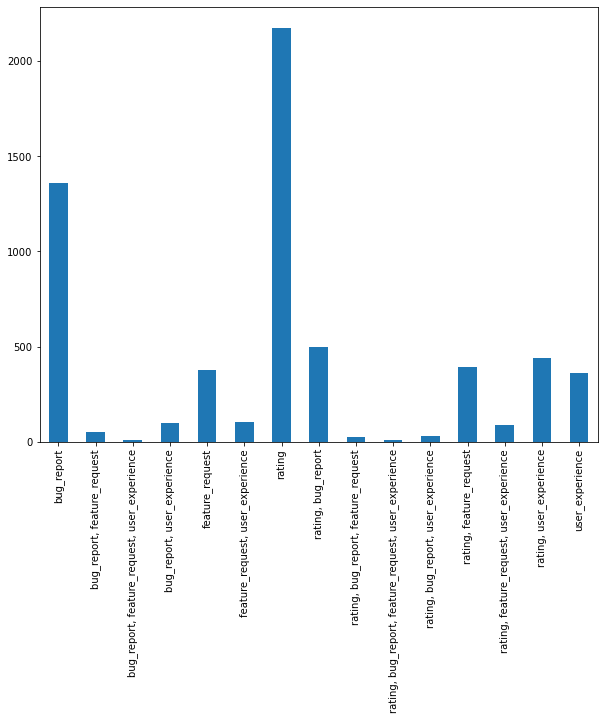

In [223]:
#data.insert(2, "Tags", [' ' for _ in range(len(data.index))], True)

tags = []

for index, row in data.iterrows():
    str_tag = ""
    if row["rating"] == 1:
        str_tag += "rating, "
    if row["bug_report"] == 1:
        str_tag += "bug_report, "
    if row["feature_request"] == 1:
        str_tag += "feature_request, "
    if row["user_experience"] == 1:
        str_tag += "user_experience, "

    tags.append(str_tag[0:-2])

#print(tags)

data.insert(2, "tags", tags, True)

#print(data.head())

data["tags"].value_counts().sort_index().plot.bar(x="Tag Distribution of All Observations", y="Number of observations")

### Tokenization 

*Tokenization* is the process of splitting an input text into tokens (words or other relevant elements, such as punctuation, empty strings). We will use the result as a basis to predict a label.


In [224]:
from nltk.tokenize import word_tokenize #principal tokenization class from nltk API
from nltk.stem import SnowballStemmer #Stemming method
import re #regex library
nltk.download('punkt')

corpus = []

for index, row in data.iterrows():
    review = re.sub('\*', '', row["data"]) # get data, substitute asterisks for empty string, put into review
    review = re.sub('[^a-zA-Z]', ' ', review) # from review, remove all non-alphabetic characters
    review = re.sub('[^\w\s]', '', review) # remove punctuation from review
    review = ' '.join([SnowballStemmer('french').stem(w) for w in word_tokenize(review.lower(), language='french')]) # apply stemming
    corpus.append(review)

#print(corpus)

data.insert(1, "token", corpus, True)

print(data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\afons\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                data  \
0  Contrairement aux idées reçues le traceur GPS ...   
1               Application très pratique et fiable.   
2                                   jadore ma montre   
3  Super application, je l'utilise synchronisé av...   
4                                            Super !   

                                               token  score  \
0  contrair aux id e re ue le traceur gp est tr s...      5   
1                      appliqu tr s pratiqu et fiabl      5   
2                                     jador ma montr      5   
3  sup appliqu je l utilis synchron avec ma fenix...      5   
4                                                sup      5   

                      tags  rating  bug_report  feature_request  \
0  rating, user_experience       1           0                0   
1                   rating       1           0                0   
2                   rating       1           0                0   
3  rating, user_

### Separation between train and test datasets
Separate in adequate proportions to avoid the overfitting of the modules the data between features and targets. In this case there will be 2 different separations, one for the original multilabel problem and another for the mold into just a multiclass problem. To ensure a more even tag distribution, we must use the *stratify* hyper-parameter

In [225]:
from sklearn.model_selection import train_test_split

features = ['token', 'score']

X = data.loc[:,features] #select from data the features

X_train_mc, X_mc, y_train_mc, y_mc = train_test_split(
    X, data['tags'], train_size=0.7, stratify=data['tags'], random_state=random.randint(0,100)
) #mc means multiclass problem

X_train_ml, X_ml, y_train_ml, y_ml = train_test_split(
    X, data_labels, train_size=0.7, stratify=data_labels, random_state=random.randint(0,100)
) #ml means multilabel problem

#print(X_train_mc)
#print(y_train_mc)
#print(X_train_ml)
#print(y_train_ml)

                                                  token  score
2985  app ne se ouvr pas il m affich que mon t l pho...      1
2360  dommag que cet appliqu ne fonction bien qu ave...      3
2648  appliqu tr s var e compt le nombr de pas dan l...      5
5881  pas moyen de d sinstall cet appliqu impos e pa...      1
1479  permet suiv optimum avec un r sum simpl pr cis...      5
...                                                 ...    ...
2721  appliqu complet quand vous avez une montr conn...      4
1507  sup appli nombreux fonctionnal s et possibil s...      5
944   au top coupl avant avec une vivoact et mainten...      5
893   synchronis impossibl avec ma forerunn depuis l...      1
462                           vrai une appliqu compl te      5

[4200 rows x 2 columns]
2985                                  bug_report
2360    rating, feature_request, user_experience
2648                             user_experience
5881                                  bug_report
1479                   